# 1. Import Modules

In [1]:
import math
import torch
import numpy as np
import pandas as pd 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error

In [2]:
if torch.cuda.is_available():
    print("Using GPU to train the model")
    device = torch.device("cuda")
else:
    print("There is no GPU in your device")
    device = torch.device("cpu")

Using GPU to train the model


# 2. Define Necessary Functions

In [278]:
def  get_close_price(data):
    df = pd.read_csv(data)["Low"]
    return (np.array(df) - np.min(df)) / (np.max(df) - np.min(df))

def split_data(squence):
    total = len(squence)
    train_idx = int(total*0.9)
    return squence[:train_idx], squence[train_idx:]

def draw_data(train, test, test_pred = [], title = ""):
    plt.figure(figsize = (12, 6))
    plt.plot(range(len(train)), train, color = "green", label = "Train")
    plt.plot(range(len(train), len(train)+len(test)), test, color = "orange", label = "Test")
    if len(test_pred) > 0:
        plt.plot(range(len(train), len(train)+len(test)), test_pred, color = "red", label = "Test - Predict")
        plt.xlim(len(train)-500, len(train)+len(test)+10)
        plt.ylim(-0.05, 0.5)
    plt.xlabel("Time")
    plt.ylabel("Scaled Stock Price")
    plt.title(title)
    plt.legend()
    plt.show()

def generate_pairs(seq, window = 20):
    X, Y = [], []
    for i in range(0,len(seq)-window):
        X.append(np.array(seq[i : i+window]).reshape(-1, 1))
        Y.append(np.array(seq[i+window]))
    return torch.from_numpy(np.array(X)).float(), torch.from_numpy(np.array(Y).reshape(-1, 1)).float()
  
def test_model(model, testX, testY, split):
    output = model(testX)
    loss = nn.MSELoss()(output, testY)
    print("%s RMSE: "%(split), np.sqrt(loss.item()))
    return output.detach().numpy()


# 3. Precess Data and Visualization

In [264]:
# load data and split into train, test
train, test = split_data(get_close_price("ABUS.csv"))

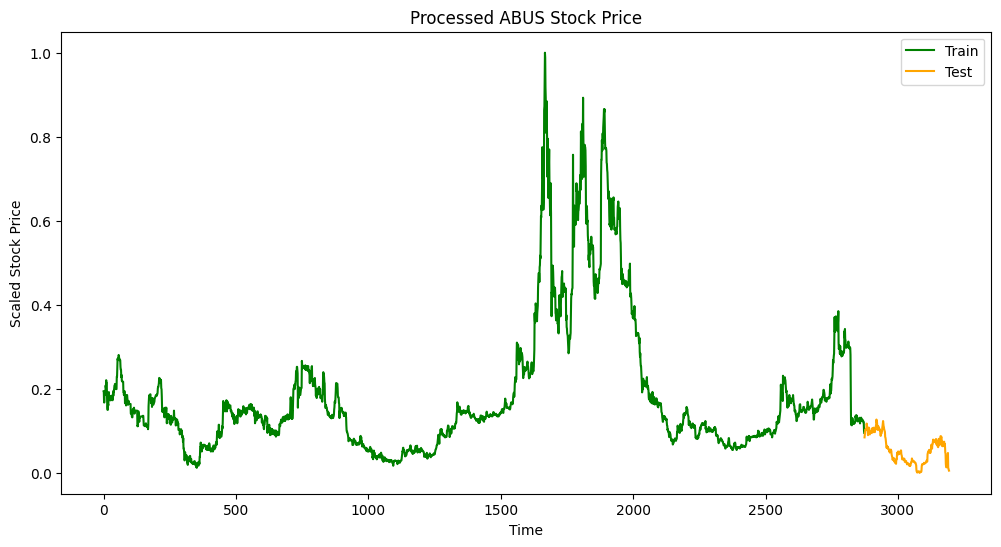

In [276]:
# visualize the main stock price
draw_data(train, test, title = "Processed ABUS Stock Price")

In [266]:
# generate input and output pairs for model training
(trainX, trainY), (testX, testY) = generate_pairs(train), generate_pairs(test)

In [267]:
trainX.shape

torch.Size([2854, 20, 1])

In [268]:
trainY.shape

torch.Size([2854, 1])

# 4. Model Building

## 4.1 Vanilla RNN

In [269]:
class RNN(nn.Module):
    def __init__(self, input_size = 1, layers = 2, hid_dim = 8, out_dim = 1):
        super(RNN,self).__init__()
        self.hid_dim=hid_dim
        self.layers=layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hid_dim, num_layers = layers)
        self.fc=nn.Linear(hid_dim, out_dim, bias=True)

    def forward(self, x):
        out, _=self.rnn(x, torch.zeros(self.layers, x.size(1), self.hid_dim))
        out = self.fc(out[:, -1])
        return out

## 4.2 LSTM

In [270]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, layers = 2, hid_dim = 8, out_dim = 1):
        super(LSTM, self).__init__()
        self.layers=layers
        self.hid_dim=hid_dim

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hid_dim, num_layers = layers)
        self.fc = nn.Linear(hid_dim, out_dim, bias=True)

    def forward(self, x):
        out, (_, _) = self.lstm(x, (torch.zeros(self.layers, x.size(1), self.hid_dim), torch.zeros(self.layers, x.size(1), self.hid_dim)))
        out=self.fc(out[:,-1])
        return out

## 4.3 GRU

In [271]:
class GRU(nn.Module):
    def __init__(self, input_size = 1, layers = 2, hid_dim = 8, out_dim = 1):
        super(GRU, self).__init__()
        self.layers = layers
        self.hid_dim = hid_dim
        self.gru = nn.GRU(input_size=input_size, hidden_size=hid_dim, num_layers = layers)
        self.fc = nn.Linear(hid_dim, out_dim, bias=True)

    def forward(self, x):
        out, (_, _) = self.gru(x, torch.zeros(self.layers, x.size(1), self.hid_dim))
        out = self.fc(out[:,-1])
        return out

## 4.4 Training Function

In [272]:
def train_model(model, trainX, trainY, valX, valY, learning_rate = 0.01, epochs = 50):
    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    train_rmse, val_rmse = [], []
    for i in range(epochs):
        
        # training process
        optimizer.zero_grad()
        out = model(trainX)
        loss = criterion(out, trainY)
        loss.backward()
        optimizer.step()
        train_rmse.append(np.sqrt(loss.item()))
        
        # validation
        vout = model(valX)
        vloss = criterion(vout, valY)
        val_rmse.append(np.sqrt(vloss.item()))
        
        if (i+1) % 5 == 0:
            print(f'epoch {i+1}, training rmse : {train_rmse[-1]:.4f}, val rmse : {val_rmse[-1]:.4f}')
            
    return train_rmse, val_rmse


### 4.4.1 Test RNN model

In [273]:
rnn_model = RNN()
train_rmse, test_rmse = train_model(rnn_model, trainX, trainY, testX, testY, learning_rate = 0.01)

epoch 5, training rmse : 0.1539, val rmse : 0.1179
epoch 10, training rmse : 0.1368, val rmse : 0.1132
epoch 15, training rmse : 0.1027, val rmse : 0.0537
epoch 20, training rmse : 0.0514, val rmse : 0.0137
epoch 25, training rmse : 0.0595, val rmse : 0.0418
epoch 30, training rmse : 0.0300, val rmse : 0.0320
epoch 35, training rmse : 0.0372, val rmse : 0.0202
epoch 40, training rmse : 0.0222, val rmse : 0.0125
epoch 45, training rmse : 0.0253, val rmse : 0.0161
epoch 50, training rmse : 0.0211, val rmse : 0.0096


RNN - Test RMSE:  0.009576087664001092


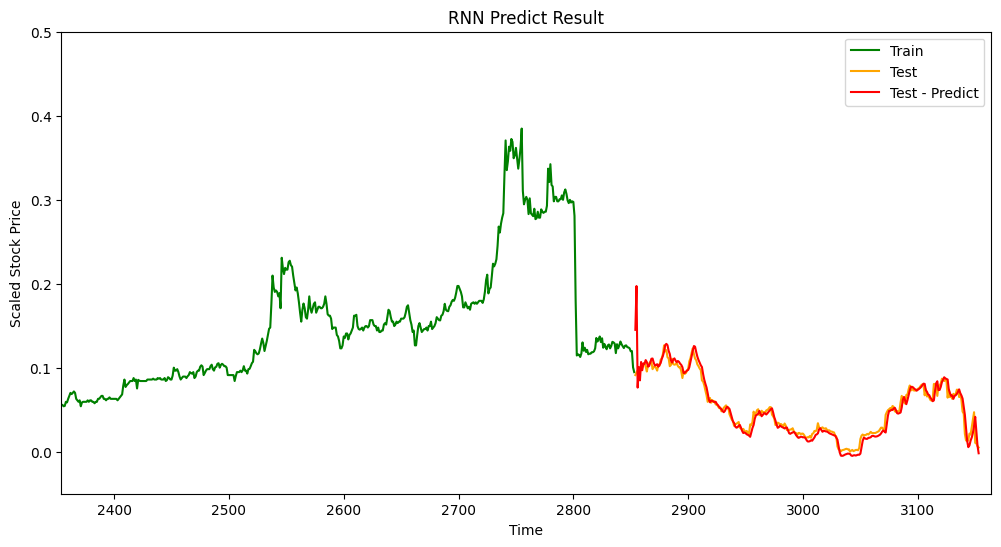

In [279]:
rnn_predict = test_model(rnn_model, testX, testY, split = "RNN - Test")
draw_data(trainY, testY, test_pred = rnn_predict, title = "RNN Predict Result")

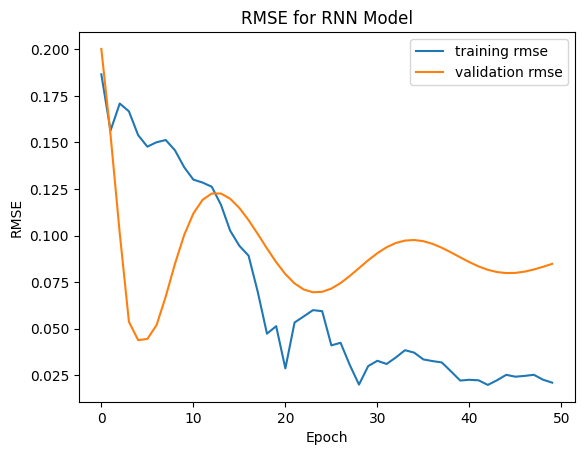

In [280]:
plt.plot(train_rmse, label = "training rmse")
plt.plot(val_rmse, label = "validation rmse")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE for RNN Model")
plt.legend()
plt.show()

### 4.4.2 Test LSTM Model

In [256]:
lstm_model = LSTM()
train_rmse, test_rmse = train_model(lstm_model, trainX, trainY, testX, testY, learning_rate = 0.01)

epoch 5, training rmse : 0.1714, val rmse : 0.0792
epoch 10, training rmse : 0.1605, val rmse : 0.1391
epoch 15, training rmse : 0.1609, val rmse : 0.1628
epoch 20, training rmse : 0.1518, val rmse : 0.1234
epoch 25, training rmse : 0.1381, val rmse : 0.0975
epoch 30, training rmse : 0.0914, val rmse : 0.0561
epoch 35, training rmse : 0.0797, val rmse : 0.0195
epoch 40, training rmse : 0.0432, val rmse : 0.0542
epoch 45, training rmse : 0.0519, val rmse : 0.0512
epoch 50, training rmse : 0.0355, val rmse : 0.0244


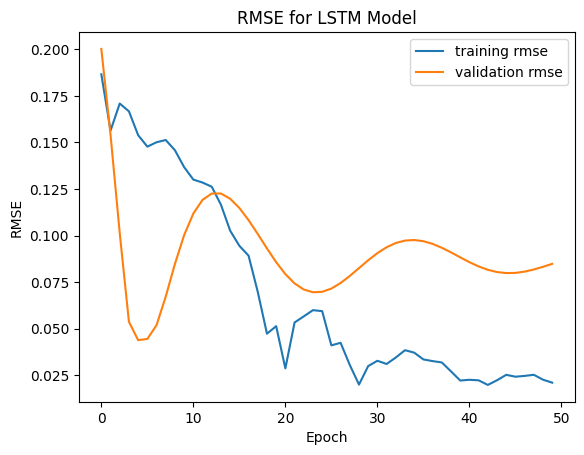

In [281]:
plt.plot(train_rmse, label = "training rmse")
plt.plot(val_rmse, label = "validation rmse")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE for LSTM Model")
plt.legend()
plt.show()

LSTM - Test RMSE:  0.024434490002554706


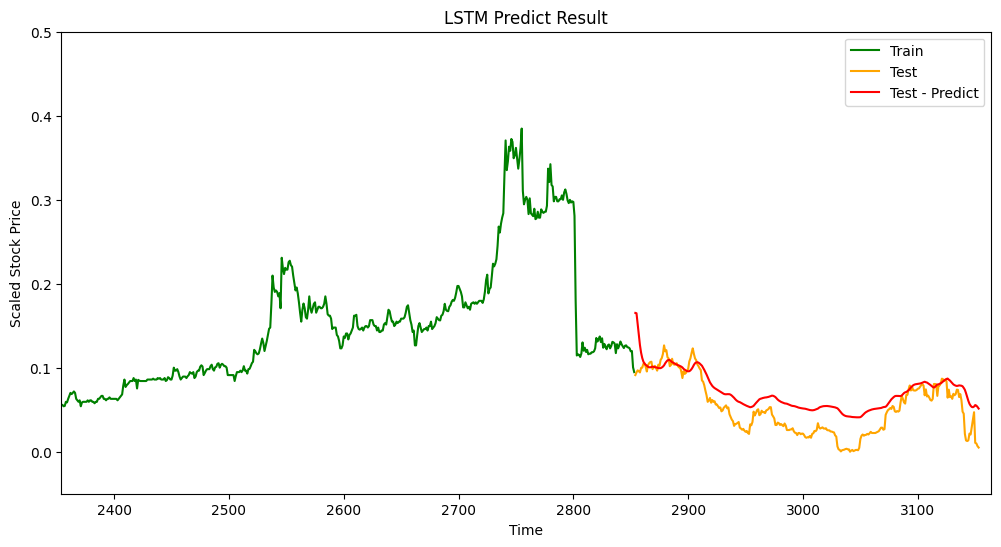

In [282]:
lstm_predict = test_model(lstm_model, testX, testY, split = "LSTM - Test")
draw_data(trainY, testY, test_pred = lstm_predict, title = "LSTM Predict Result")

### 4.4.3 Test GRU Model

In [259]:
gru_model = GRU()
train_rmse, test_rmse = train_model(gru_model, trainX, trainY, testX, testY, learning_rate = 0.01)

epoch 5, training rmse : 0.1885, val rmse : 0.2046
epoch 10, training rmse : 0.1411, val rmse : 0.0383
epoch 15, training rmse : 0.1085, val rmse : 0.0905
epoch 20, training rmse : 0.0962, val rmse : 0.0986
epoch 25, training rmse : 0.0610, val rmse : 0.0161
epoch 30, training rmse : 0.0319, val rmse : 0.0205
epoch 35, training rmse : 0.0403, val rmse : 0.0571
epoch 40, training rmse : 0.0341, val rmse : 0.0112
epoch 45, training rmse : 0.0242, val rmse : 0.0186
epoch 50, training rmse : 0.0244, val rmse : 0.0181


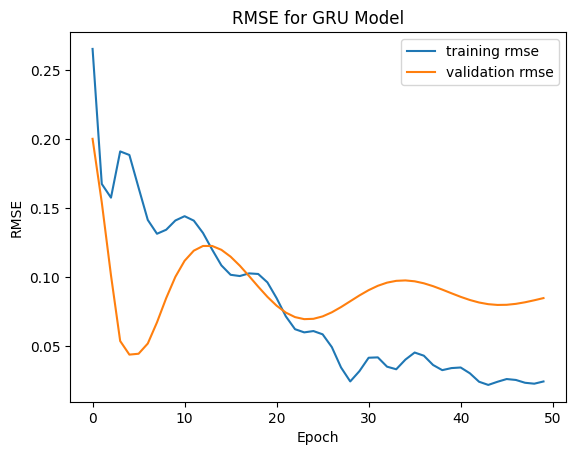

In [261]:
plt.plot(train_rmse, label = "training rmse")
plt.plot(val_rmse, label = "validation rmse")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE for GRU Model")
plt.legend()
plt.show()

GRU - Test RMSE:  0.018080322602090186


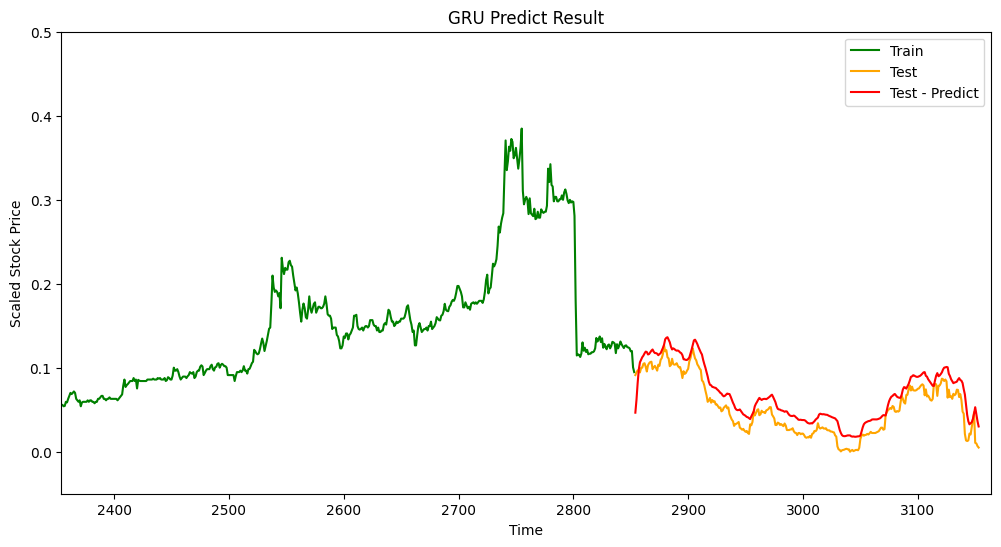

In [283]:
gru_predict = test_model(gru_model, testX, testY, split = "GRU - Test")
draw_data(trainY, testY, test_pred = gru_predict, title = "GRU Predict Result")

# 5. Experiments 

Since the RNN achieves the best RMSE in part 4, the following ablation study will mainly foucs on the RNN model.

## 5.1 Window Size Test

In [284]:
# generate pairs with 15 window size
(trainX_15, trainY_15), (testX_15, testY_15) = generate_pairs(train, window = 15), generate_pairs(test, window=15)

In [285]:
rnn_model_15 = RNN()
train_rmse, test_rmse = train_model(rnn_model_15, trainX_15, trainY_15, testX_15, testY_15, learning_rate = 0.01)

epoch 5, training rmse : 0.2017, val rmse : 0.2590
epoch 10, training rmse : 0.1590, val rmse : 0.0402
epoch 15, training rmse : 0.1444, val rmse : 0.1333
epoch 20, training rmse : 0.1504, val rmse : 0.1595
epoch 25, training rmse : 0.1339, val rmse : 0.0696
epoch 30, training rmse : 0.1153, val rmse : 0.1077
epoch 35, training rmse : 0.0921, val rmse : 0.0665
epoch 40, training rmse : 0.0491, val rmse : 0.0312
epoch 45, training rmse : 0.0497, val rmse : 0.0543
epoch 50, training rmse : 0.0467, val rmse : 0.0490


RNN - Test - Window size 15 -  RMSE:  0.04902426901336305


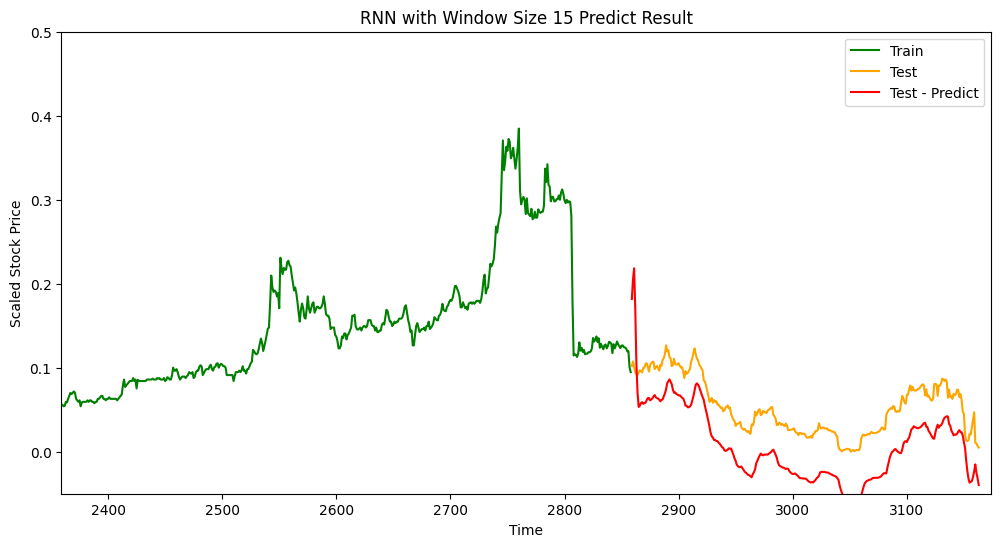

In [286]:
rnn_predict_15 = test_model(rnn_model_15, testX_15, testY_15, split = "RNN - Test - Window size 15 - ")
draw_data(trainY_15, testY_15, test_pred = rnn_predict_15, title = "RNN with Window Size 15 Predict Result")

In [287]:
# generate pairs with 25 window size
(trainX_25, trainY_25), (testX_25, testY_25) = generate_pairs(train, window = 25), generate_pairs(test, window=25)
rnn_model_25 = RNN()
train_rmse, test_rmse = train_model(rnn_model_25, trainX_25, trainY_25, testX_25, testY_25, learning_rate = 0.01)

epoch 5, training rmse : 0.1425, val rmse : 0.1780
epoch 10, training rmse : 0.1180, val rmse : 0.0415
epoch 15, training rmse : 0.0645, val rmse : 0.0323
epoch 20, training rmse : 0.0624, val rmse : 0.0155
epoch 25, training rmse : 0.0268, val rmse : 0.0300
epoch 30, training rmse : 0.0355, val rmse : 0.0155
epoch 35, training rmse : 0.0301, val rmse : 0.0219
epoch 40, training rmse : 0.0179, val rmse : 0.0152
epoch 45, training rmse : 0.0244, val rmse : 0.0166
epoch 50, training rmse : 0.0178, val rmse : 0.0111


RNN - Test - Window size 25 -  RMSE:  0.011149353206351829


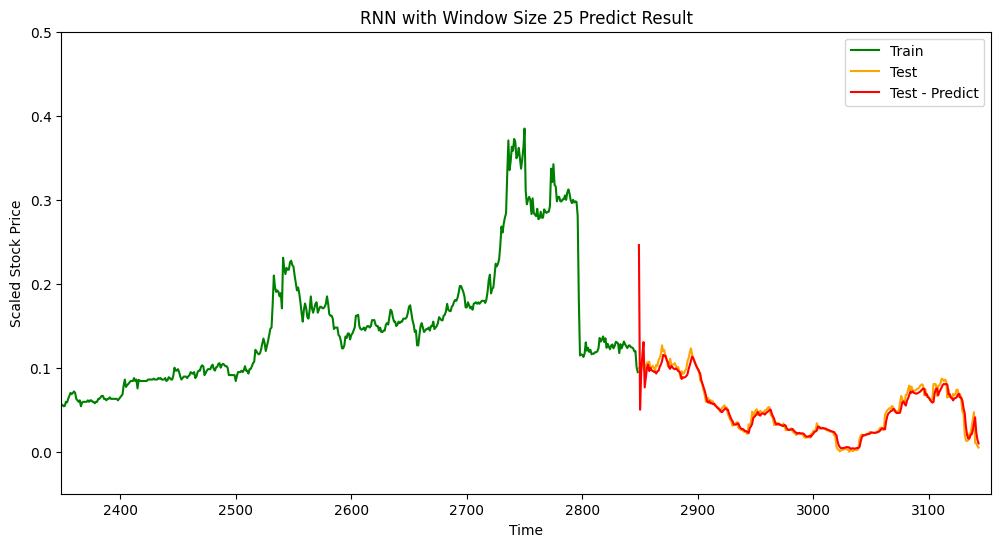

In [288]:
rnn_predict_25 = test_model(rnn_model_25, testX_25, testY_25, split = "RNN - Test - Window size 25 - ")
draw_data(trainY_25, testY_25, test_pred = rnn_predict_25, title = "RNN with Window Size 25 Predict Result")

## 5.2 Learning Rate Test 

In [289]:
# set learning rate 0.05
rnn_model_lr1 = RNN()
train_rmse, test_rmse = train_model(rnn_model_lr1, trainX, trainY, testX, testY, learning_rate = 0.05)

epoch 5, training rmse : 0.1574, val rmse : 0.1911
epoch 10, training rmse : 0.1380, val rmse : 0.0481
epoch 15, training rmse : 0.0594, val rmse : 0.0326
epoch 20, training rmse : 0.0421, val rmse : 0.0229
epoch 25, training rmse : 0.0447, val rmse : 0.0393
epoch 30, training rmse : 0.0252, val rmse : 0.0308
epoch 35, training rmse : 0.0305, val rmse : 0.0168
epoch 40, training rmse : 0.0253, val rmse : 0.0235
epoch 45, training rmse : 0.0216, val rmse : 0.0154
epoch 50, training rmse : 0.0223, val rmse : 0.0141


RNN - Test - Learning Rate 0.05 -  RMSE:  0.01411667573144504


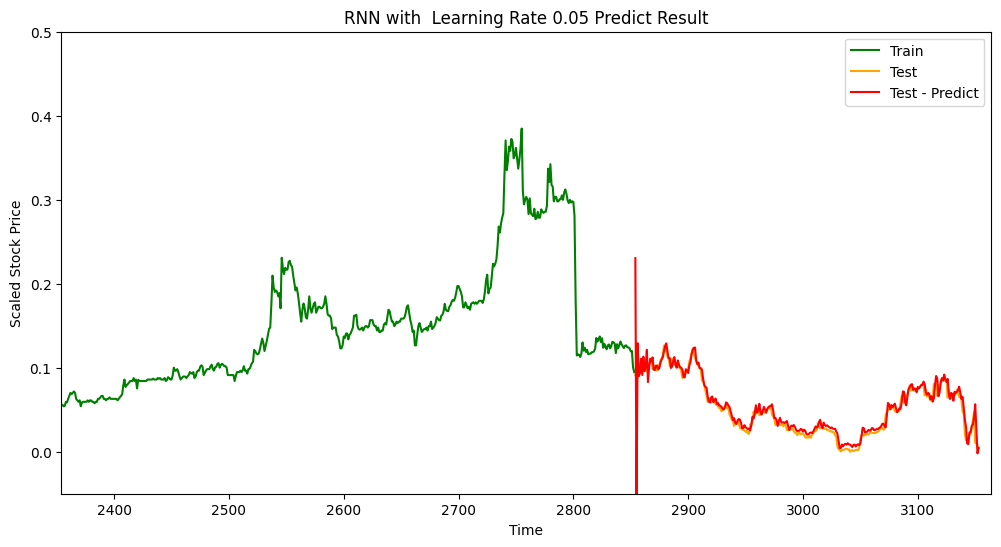

In [290]:
rnn_predict_lr1 = test_model(rnn_model_lr1, testX, testY, split = "RNN - Test - Learning Rate 0.05 - ")
draw_data(trainY, testY, test_pred = rnn_predict_lr1, title = "RNN with  Learning Rate 0.05 Predict Result")

In [291]:
# set learning rate 0.005
rnn_model_lr2 = RNN()
train_rmse, test_rmse = train_model(rnn_model_lr2, trainX, trainY, testX, testY, learning_rate = 0.005)

epoch 5, training rmse : 0.2268, val rmse : 0.0428
epoch 10, training rmse : 0.1684, val rmse : 0.2019
epoch 15, training rmse : 0.1781, val rmse : 0.1994
epoch 20, training rmse : 0.1567, val rmse : 0.1200
epoch 25, training rmse : 0.1599, val rmse : 0.0855
epoch 30, training rmse : 0.1503, val rmse : 0.1086
epoch 35, training rmse : 0.1412, val rmse : 0.1366
epoch 40, training rmse : 0.1258, val rmse : 0.1014
epoch 45, training rmse : 0.1026, val rmse : 0.0446
epoch 50, training rmse : 0.0605, val rmse : 0.0314


RNN - Test - Learning Rate 0.005 -  RMSE:  0.03136067981481062


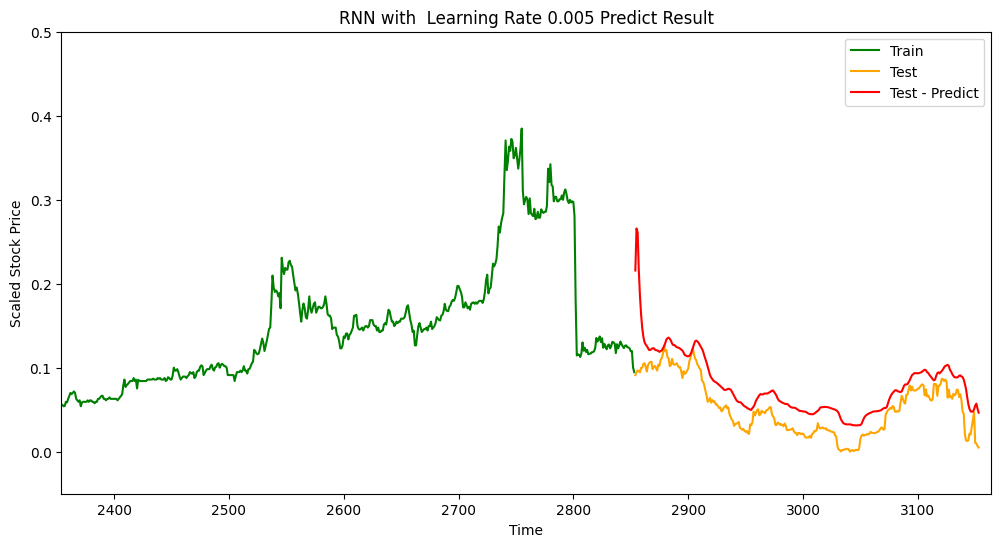

In [292]:
rnn_predict_lr2 = test_model(rnn_model_lr2, testX, testY, split = "RNN - Test - Learning Rate 0.005 - ")
draw_data(trainY, testY, test_pred = rnn_predict_lr2, title = "RNN with  Learning Rate 0.005 Predict Result")